In [1]:
import pandas as pd
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt


In [2]:
def load_from_csv(filename='pred_and_erroroutput.csv'):
    # read from csv
    df = pd.read_csv(filename)
    
    # get number of columns
    num_columns = df.shape[1]
    
    # every block ahs same amount of columns
    block_size = num_columns // 3
    
    # first block (Simulation data)
    data = df.iloc[:, :block_size].values
    
    # 2 block  (actual_predictions)
    actual_predictions = df.iloc[:, block_size:2*block_size].values
    
    # 3rd block (pred_error)
    pred_error = df.iloc[:, 2*block_size:].values
    
    return data, actual_predictions, pred_error

In [3]:
def calculate_single_mean_error(pred_error):
    
    # Calc mean error per time step
    mean_pred_error_of_line_list = np.mean(pred_error, axis=1)
    # print(len(mean_pred_error_of_line_list))
    
    # calc totel mean error
    single_mean_error = np.mean(mean_pred_error_of_line_list)
    
    return single_mean_error, mean_pred_error_of_line_list

In [4]:
# Parameters
L = 1  # Length of the domain
T = 1.5  # Total time
nx = 60  # Number of spatial points
nt = 751 # Number of time steps
alpha = 0.05  # Diffusion coefficient

dx = L / (nx - 1)
dt = T / nt

time = np.linspace(0, T, nt)

# Avoid that results converge to inifinity
if alpha * dt / dx**2 > 0.5:
    raise ValueError("Stability condition violated")

In [5]:
# laod csv
ground_truth_data, prediction_data, pred_error_data = load_from_csv(filename='pred_and_errordatadriven_700epochs_sinus_diffusion.csv')
ground_truth_Heat_conserv, prediction_Heat_conserv, pred_error_Heat_conserv = load_from_csv(filename='pred_and_errorHeat_Conservation_700epochs_sinus_diffusion.csv')
ground_truth_Heat_eq, prediction_Heat_eq, pred_error_Heat_eq = load_from_csv(filename='pred_and_errorHeat_equation_700epochs_sinus_diffusion.csv')

# single_mean_error calculatino
single_mean_error_data, single_mean_error_data_list = calculate_single_mean_error(pred_error_data)
single_mean_error_Heat_conserv, single_mean_error_Heat_conserv_list = calculate_single_mean_error(pred_error_Heat_conserv)
single_mean_error_Heat_eq, single_mean_error_Heat_eq_list = calculate_single_mean_error(pred_error_Heat_eq)


In [6]:
def heat_distribution_and_error_plotter(actual_predictions, absolute_pred_error, L, nx, time):
    # create figure
    fig = plt.figure(figsize=(12, 5))
    
    # 1. Subplot: 3D-Plot with coloured error
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    time = time[:len(actual_predictions)]
    # Create grid for position and time
    x = np.linspace(0, L, nx)
    X, T_grid = np.meshgrid(x, time)

    # Transform Temperature and Errox Matrix for the plot
    Z = actual_predictions
    error_z = absolute_pred_error

    # scale the error for the colouring
    error_normalized = (error_z - np.min(error_z)) / (np.max(error_z) - np.min(error_z))

    # Define colormap
    cmap = plt.colormaps['RdYlGn_r']

    # create the plot surface
    surf = ax.plot_surface(X, T_grid, Z, facecolors=cmap(error_normalized), edgecolor='none', shade=True)

    # In case you wanna plot the unscaled data
    # surf = ax.plot_surface(X, T_grid, Z, facecolors=cmap(absolute_pred_error), edgecolor='none', shade=True)

    # Create ScalarMappable-Object for colorbar
    mappable = plt.cm.ScalarMappable(cmap=cmap)
    mappable.set_array(absolute_pred_error)
    mappable.set_clim(vmin=np.min(absolute_pred_error), vmax=np.max(absolute_pred_error))

    # add colorbar
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10, location="left", label="Vorhersagefehler")

    ax.set_title("Temperaturverteilung über die Zeit mit Fehlerkennzeichnung")
    ax.set_xlabel("Position x (m)")
    ax.set_ylabel("Zeit t (s)")
    ax.set_zlabel("Temperatur T (°C)")

    # 2. Subplot: 2D-Plot begin temperature and end temperature
    ax2 = fig.add_subplot(1, 2, 2)
    Initial_temp_dist = actual_predictions[0]
    Final_temp_dist = actual_predictions[-1]

    ax2.plot(x, Initial_temp_dist, color='green', label="Anfangstemperatur")
    ax2.plot(x, Final_temp_dist, color='red', label="Endtemperatur")
    ax2.set_title("Anfangs- und Endtemperatur")
    ax2.set_xlabel("Position x (m)")
    ax2.set_ylabel("Temperatur T (°C)")
    ax2.legend()

    # more distance between plots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

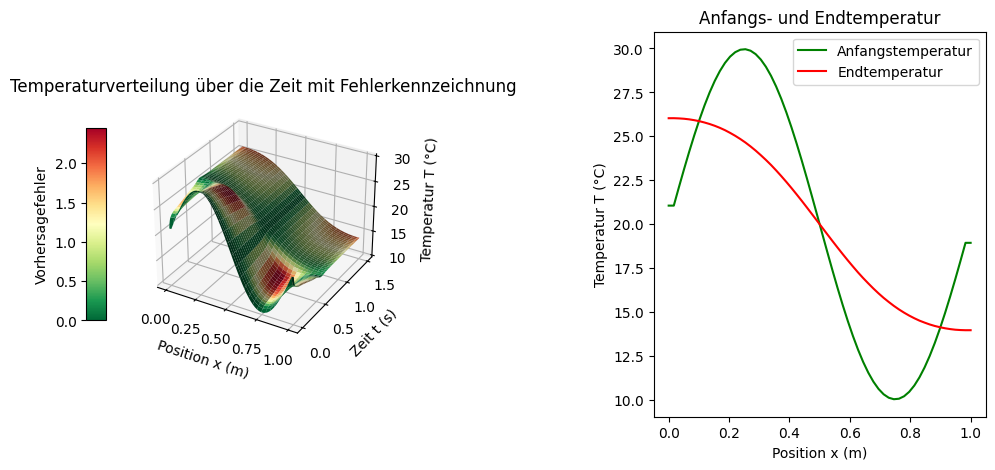

In [7]:
heat_distribution_and_error_plotter(prediction_data, pred_error_data, L, nx, time)

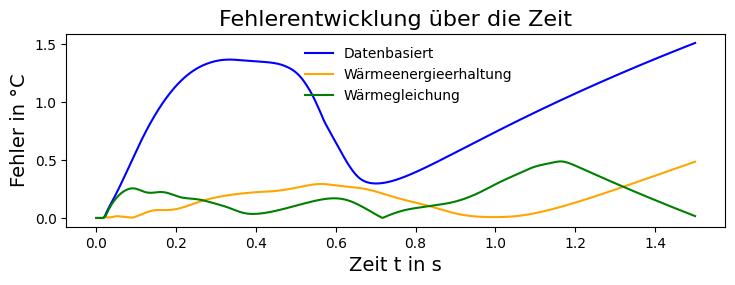

In [8]:
# 4. Subplot: plot over time error
fig = plt.figure(figsize=(8.5, 2.5))
single_mean_error_data, single_mean_error_data_list = calculate_single_mean_error(pred_error_data)
single_mean_error_Heat_conserv, single_mean_error_Heat_conserv_list = calculate_single_mean_error(pred_error_Heat_conserv)
single_mean_error_Heat_eq, single_mean_error_Heat_eq_list = calculate_single_mean_error(pred_error_Heat_eq)

plt.plot(time, single_mean_error_data_list, label='Datenbasiert', color='blue')
plt.plot(time, single_mean_error_Heat_conserv_list, label='Wärmeenergieerhaltung', color='orange')
plt.plot(time, single_mean_error_Heat_eq_list, label='Wärmegleichung', color='green')

plt.title("Fehlerentwicklung über die Zeit", fontsize = 16)
plt.xlabel("Zeit t in s", fontsize = 14)
plt.ylabel("Fehler in °C", fontsize = 14)
plt.legend(loc='upper center', bbox_to_anchor = (0.52, 1), frameon=False)


In [9]:
def heat_distribution_and_error_plotter(ground_truth_data, prediction_data, pred_error_data,
                                       ground_truth_Heat_conserv, prediction_Heat_conserv, pred_error_Heat_conserv,
                                       ground_truth_Heat_eq, prediction_Heat_eq, pred_error_Heat_eq,
                                       L, nx, time):
    # Create figure
    fig = plt.figure(figsize=(10, 12))
    # fig.suptitle('Wärmediffusion Sinus-Verteilung', fontsize=16, y=1.02, ha='center')

    # Define common colrmap
    cmap = plt.colormaps['RdYlGn_r']
    error_min = min(np.min(pred_error_data), np.min(pred_error_Heat_conserv), np.min(pred_error_Heat_eq))
    error_max = max(np.max(pred_error_data), np.max(pred_error_Heat_conserv), np.max(pred_error_Heat_eq))

    # 1. Subplot: 3D-Plot Data
    ax1 = fig.add_subplot(3, 1, 1, projection='3d')
    plot_3d_surface(ax1, ground_truth_data, pred_error_data, L, nx, time, "Datenbasiert - Vorhersage", cmap, error_min, error_max)

    # 2. Subplot: 3D-Plot Heat conserv
    ax2 = fig.add_subplot(3, 1, 2, projection='3d')
    plot_3d_surface(ax2, ground_truth_Heat_conserv, pred_error_Heat_conserv, L, nx, time, "Wärmeenergieerhaltung - Vorhersage", cmap, error_min, error_max)

    # 3. Subplot: 3D-Plot Heat Eq
    ax3 = fig.add_subplot(3, 1, 3, projection='3d')
    plot_3d_surface(ax3, ground_truth_Heat_eq, pred_error_Heat_eq, L, nx, time, "Wärmegleichung - Vorhersage", cmap, error_min, error_max)

    # Add common Colormap
    mappable = plt.cm.ScalarMappable(cmap=cmap)
    mappable.set_clim(vmin=error_min, vmax=error_max)
    
    # Horizontal positioning of the colorbar
    cbar_ax = fig.add_axes([0.35, 0.95, 0.35, 0.02])  # [left, bottom, width, height]
    cbar_ax.set_title("Temperatur - Vorhersagefehler in °C", fontsize = 16, pad=15)
    cbar = fig.colorbar(mappable, cax=cbar_ax, orientation='horizontal')

    # Show plot
    plt.tight_layout(pad=3.0, w_pad=1.0, h_pad=2.0)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_3d_surface(ax, actual_predictions, absolute_pred_error, L, nx, time, title, cmap, error_min, error_max):
    # Create grid from Position (x) and time (t)
    x = np.linspace(0, L, nx)
    X, T_grid = np.meshgrid(x, time)

    Z = actual_predictions
    error_z = absolute_pred_error

    # scale error in range 0 to 1
    error_normalized = (error_z - error_min) / (error_max - error_min)

    # create coloured surface
    surf = ax.plot_surface(X, T_grid, Z, facecolors=cmap(error_normalized), edgecolor='none', shade=True)

    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Stabposition x in m")
    ax.set_ylabel("Zeit t in s")
    ax.set_zlabel("Temperatur T in °C")

C:\Users\lauto\AppData\Local\Temp\ipykernel_32384\1620365956.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0, w_pad=1.0, h_pad=2.0)


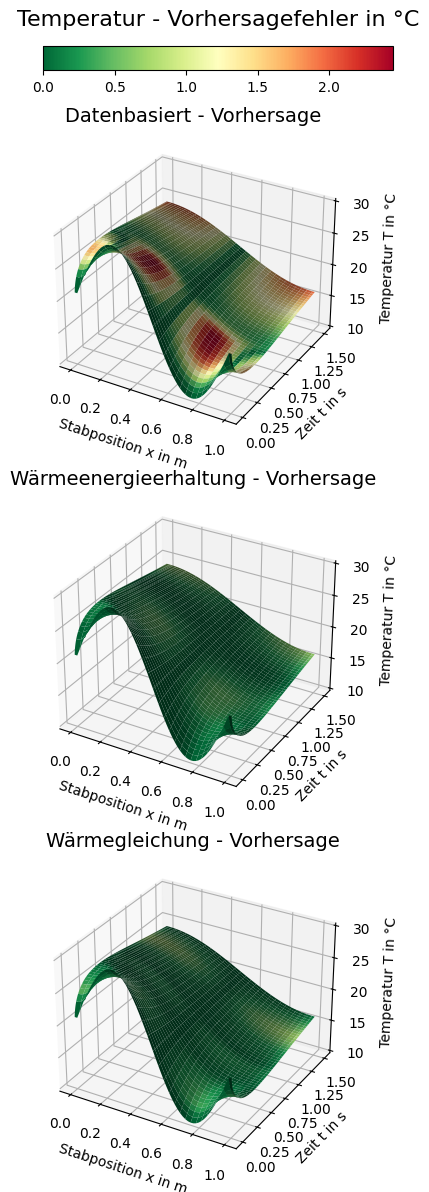

In [10]:
time = np.linspace(0, T, nt)

heat_distribution_and_error_plotter(ground_truth_data, prediction_data, pred_error_data,
                                   ground_truth_Heat_conserv, prediction_Heat_conserv, pred_error_Heat_conserv,
                                   ground_truth_Heat_eq, prediction_Heat_eq, pred_error_Heat_eq,
                                   L, nx, time)

In [11]:
def plot_3d_and_error_over_time(ax1, ax2, ground_truth, pred_error, time, L, nx, title, cmap, error_min, error_max):

    # 3D-Plot
    plot_3d_surface(ax1, ground_truth, pred_error, L, nx, time, title, cmap, error_min, error_max)
    
    # Fehler-über-Zeit-Plot
    single_mean_error, single_mean_error_list = calculate_single_mean_error(pred_error)
    ax2.plot(time, single_mean_error_list, label=title, color='blue')
    ax2.set_title(f"Fehler über die Zeit ({title})")
    ax2.set_xlabel("Zeit t (s)")
    ax2.set_ylabel("Mittlerer Fehler")
    ax2.legend()

def heat_distribution_and_error_plotter(plot_size, data, error_data,L, nx, time):
    """
    Hauptfunktion zum Erstellen der Plots.
    """
    # Erstelle die Figur und die Achsen
    fig = plt.figure(figsize=plot_size)  # Größere Figur für 3x2 Subplots

    # Definiere eine gemeinsame Colormap und Skala für die Fehler
    cmap = plt.colormaps['RdYlGn_r']
    error_min = np.min(error_data)
    error_max = np.max(error_data)

    # 1. Modell: Datenbasiert
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2)
    plot_3d_and_error_over_time(ax1, ax2, data, error_data, time, L, nx, "Datenbasiert", cmap, error_min, error_max)

    # Füge eine gemeinsame Colorbar hinzu
    mappable = plt.cm.ScalarMappable(cmap=cmap)
    mappable.set_clim(vmin=error_min, vmax=error_max)
    
    cbar_ax = fig.add_axes([0.05, 0.55, 0.02, 0.3])
    
    cbar = fig.colorbar(mappable, ax=[ax1], shrink=0.6, aspect=10, cax=cbar_ax, label="Vorhersagefehler")

    # Zeige den Plot an
    plt.tight_layout(pad=3.0, w_pad=1.0, h_pad=5.0)
    plt.show()

def plot_3d_surface(ax, actual_predictions, absolute_pred_error, L, nx, time, title, cmap, error_min, error_max):
    """
    Erstellt einen 3D-Oberflächenplot.
    """
    # Erstelle ein Gitter aus Position (x) und Zeit (t)
    x = np.linspace(0, L, nx)
    X, T_grid = np.meshgrid(x, time)

    # Transponiere die Temperatur- und Fehlermatrix für den Plot
    Z = actual_predictions
    error_z = absolute_pred_error

    # Normiere den Fehler für die Farbgebung (0 bis 1)
    error_normalized = (error_z - error_min) / (error_max - error_min)

    # Erstelle die Oberfläche mit Farben basierend auf dem Fehler
    surf = ax.plot_surface(X, T_grid, Z, facecolors=cmap(error_normalized), edgecolor='none', shade=True)

    ax.set_title(title)
    ax.set_xlabel("Position x (m)")
    ax.set_ylabel("Zeit t (s)")
    ax.set_zlabel("Temperatur T (°C)")

C:\Users\lauto\AppData\Local\Temp\ipykernel_32384\3167776477.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0, w_pad=1.0, h_pad=5.0)


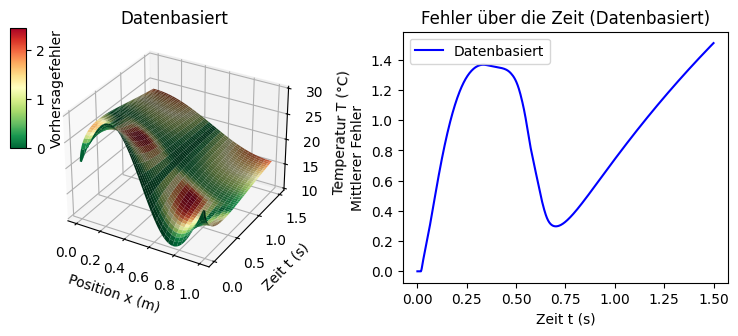

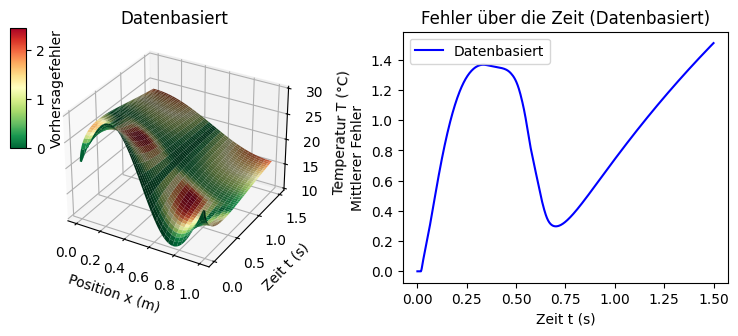

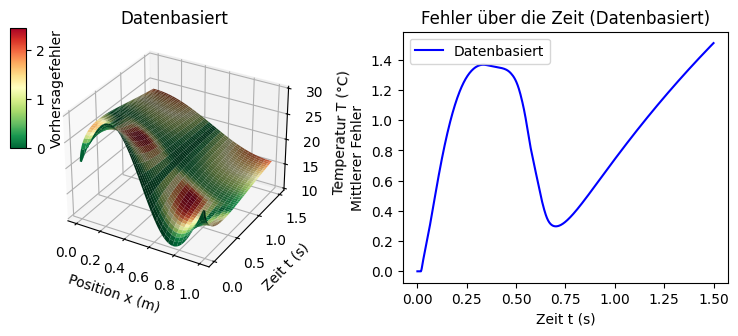

In [12]:
time = np.linspace(0, T, nt)
plot_size = (8, 4)

heat_distribution_and_error_plotter(plot_size, ground_truth_data, pred_error_data, L, nx, time)
heat_distribution_and_error_plotter(plot_size, ground_truth_Heat_conserv, pred_error_data, L, nx, time)
heat_distribution_and_error_plotter(plot_size, ground_truth_Heat_eq, pred_error_data, L, nx, time)




In [13]:
def heat_distribution_and_error_plotter(ground_truth_data, prediction_data, pred_error_data,
                                       ground_truth_Heat_conserv, prediction_Heat_conserv, pred_error_Heat_conserv,
                                       ground_truth_Heat_eq, prediction_Heat_eq, pred_error_Heat_eq,
                                       L, nx, time):
    # Erstelle die Figur und die Achsen
    fig = plt.figure(figsize=(8.5, 5))  # Größere Figur für 3x2 Subplots

    # Definiere eine gemeinsame Colormap und Skala für die Fehler
    cmap = plt.colormaps['RdYlGn_r']
    error_min = min(np.min(pred_error_data), np.min(pred_error_Heat_conserv), np.min(pred_error_Heat_eq))
    error_max = max(np.max(pred_error_data), np.max(pred_error_Heat_conserv), np.max(pred_error_Heat_eq))

    # 1. Subplot: 3D-Plot für die erste CSV-Datei (data)
    ax1 = fig.add_subplot(2, 3, 1, projection='3d')
    plot_3d_surface(ax1, ground_truth_data, pred_error_data, L, nx, time, "Datenbasiert", cmap, error_min, error_max)

    # 2. Subplot: 3D-Plot für die zweite CSV-Datei (Heat Conservation)
    ax2 = fig.add_subplot(2, 3, 2, projection='3d')
    plot_3d_surface(ax2, ground_truth_Heat_conserv, pred_error_Heat_conserv, L, nx, time, "Wärmeenergieerhaltung", cmap, error_min, error_max)

    # 3. Subplot: 3D-Plot für die dritte CSV-Datei (Heat Equation)
    ax3 = fig.add_subplot(2, 3, 3, projection='3d')
    plot_3d_surface(ax3, ground_truth_Heat_eq, pred_error_Heat_eq, L, nx, time, "Wärmegleichung", cmap, error_min, error_max)

    # 4. Subplot: Fehler über die Zeit plotten
    ax4 = fig.add_subplot(2, 1, 2)
    single_mean_error_data, single_mean_error_data_list = calculate_single_mean_error(pred_error_data)
    single_mean_error_Heat_conserv, single_mean_error_Heat_conserv_list = calculate_single_mean_error(pred_error_Heat_conserv)
    single_mean_error_Heat_eq, single_mean_error_Heat_eq_list = calculate_single_mean_error(pred_error_Heat_eq)

    ax4.plot(time, single_mean_error_data_list, label='Datenbasiert', color='blue')
    ax4.plot(time, single_mean_error_Heat_conserv_list, label='Wärmeenergieerhaltung', color='orange')
    ax4.plot(time, single_mean_error_Heat_eq_list, label='Wärmegleichung', color='green')

    ax4.set_title("Fehlerentwicklung über die Zeit")
    ax4.set_xlabel("Zeit t in s")
    ax4.set_ylabel("Fehler in °C")
    ax4.legend(loc='upper center', bbox_to_anchor = (0.52, 1), frameon=False)

    # Füge eine gemeinsame Colorbar hinzu
    mappable = plt.cm.ScalarMappable(cmap=cmap)
    mappable.set_clim(vmin=error_min, vmax=error_max)
    
    cbar_ax = fig.add_axes([0.05, 0.55, 0.02, 0.3])
    
    cbar = fig.colorbar(mappable, ax=[ax1, ax2, ax3], shrink=0.6, aspect=10, cax=cbar_ax, label="Vorhersagefehler in °C")

    # Zeige den Plot an
    plt.tight_layout(pad=3.0, w_pad=1.0, h_pad=5.0)
    plt.show()

def plot_3d_surface(ax, actual_predictions, absolute_pred_error, L, nx, time, title, cmap, error_min, error_max):
    # Erstelle ein Gitter aus Position (x) und Zeit (t)
    x = np.linspace(0, L, nx)
    X, T_grid = np.meshgrid(x, time)

    # Transponiere die Temperatur- und Fehlermatrix für den Plot
    Z = actual_predictions
    error_z = absolute_pred_error

    # Normiere den Fehler für die Farbgebung (0 bis 1)
    error_normalized = (error_z - error_min) / (error_max - error_min)

    # Erstelle die Oberfläche mit Farben basierend auf dem Fehler
    surf = ax.plot_surface(X, T_grid, Z, facecolors=cmap(error_normalized), edgecolor='none', shade=True)

    ax.set_title(title)
    ax.set_xlabel("Stabposition x (m)")
    ax.set_ylabel("Zeit t (s)")
    ax.set_zlabel("Temperatur T (°C)")

C:\Users\lauto\AppData\Local\Temp\ipykernel_32384\394506526.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0, w_pad=1.0, h_pad=5.0)


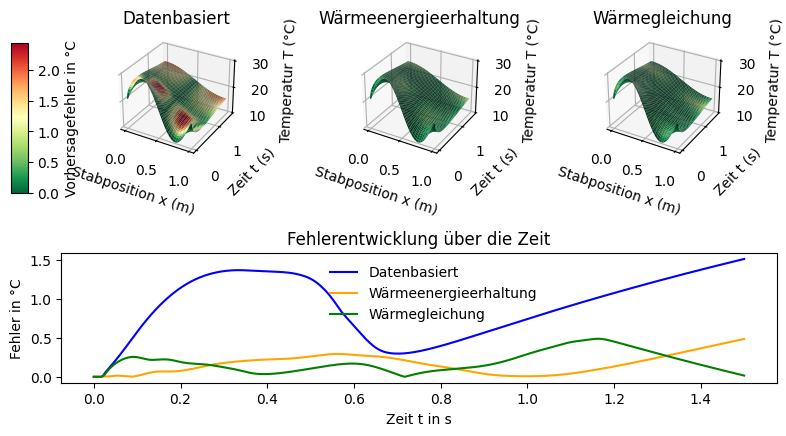

In [14]:
time = np.linspace(0, T, nt)

heat_distribution_and_error_plotter(ground_truth_data, prediction_data, pred_error_data,
                                   ground_truth_Heat_conserv, prediction_Heat_conserv, pred_error_Heat_conserv,
                                   ground_truth_Heat_eq, prediction_Heat_eq, pred_error_Heat_eq,
                                   L, nx, time)